# Model quality estimation

In [1]:
import numpy as np
import pandas as pd

Supose I want to predict if a person will get a heart failure based on some personal and medical information. Here is data:

In [12]:
data = pd.read_csv('data/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Attribute information:
- Age: age of the patient (years)
- Sex: sex of the patient (M: Male, F: Female)
- ChestPainType: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)
- RestingBP: resting blood pressure (mm Hg)
- Cholesterol: serum cholesterol (mm/dl)
- FastingBS: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
- RestingECG: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria)
- MaxHR: maximum heart rate achieved (Numeric value between 60 and 202)
- ExerciseAngina: exercise-induced angina (Y: Yes, N: No)
- Oldpeak: oldpeak = ST (Numeric value measured in depression)
- ST_Slope: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)
- HeartDisease: output class (1: heart disease, 0: Normal)


In [17]:
# Converting all features to numerical
from sklearn.preprocessing import LabelEncoder
import pandas as pd

label_encoder = LabelEncoder()
data["Sex"] = label_encoder.fit_transform(data["Sex"])
data["ChestPainType"] = label_encoder.fit_transform(data["ChestPainType"])
data["RestingECG"] = label_encoder.fit_transform(data["RestingECG"])
data["ExerciseAngina"] = label_encoder.fit_transform(data["ExerciseAngina"])
data["ST_Slope"] = label_encoder.fit_transform(data["ST_Slope"])

In [16]:
data.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


Now, I have a new patient with some feature values and I need to predict if it will have a heart attack.

In order to do that, I need to build a supervised classification model, that link features with the value to predict.

Which of the large collection of available machine learning methods should I use?

## Cross validation

Cross Validation allows us to compare different machine learning methods and get a sense of how well will work in practice. 
- The main purpose of cross-validation is to obtain a more reliable estimate of how well a model will perform on unseen data. 
- It helps assess the model's ability to generalize by simulating the scenario of applying the model to new, independent datasets.

For solving our original problem, I need to use the available data.

In [18]:
print("Available objects: ", len(data))
data.head()

Available objects:  918


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


I need to use the objects for two things:
1. Training the model, estimating their inner parameters of the method. 
- If I am using a linear classifier, I need to estimate the coefficients and bias.
- If I am using a decision tree, I need to build the tree nodes and relate them together.
2. Evaluate how well the model built works.

But:
- I need to use as much data as I can in order to train a better model
- I need to use as much data as I can in order to accuratelly estimate how well the model works
- I have a simple set of data and I cannot get more

### Use all data for training and all for testing

In [10]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 

In [22]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

clf = DecisionTreeClassifier()
clf = clf.fit(X,y)

y_pred = clf.predict(X)
metrics.accuracy_score(y, y_pred)

1.0

It looks suspicious, and we already know that when an algorithm performs too well on training data ....
- **Yes, overtraining**

**We need to use different data to train and to test the models!!**

But how can we split the data?

### Shuffle-Split Cross-Validation
This technique randomly shuffles the dataset and splits it into train and test sets multiple times. It allows for control over the train-test split size and the number of iterations.

In [110]:
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
scores = cross_val_score(clf, X, y, cv=cv)
print(scores)
scores.mean()

[0.79710145 0.77173913 0.78985507 0.80434783 0.80072464]


0.7927536231884058

Results depends on the ratio of training/testing objects taken.

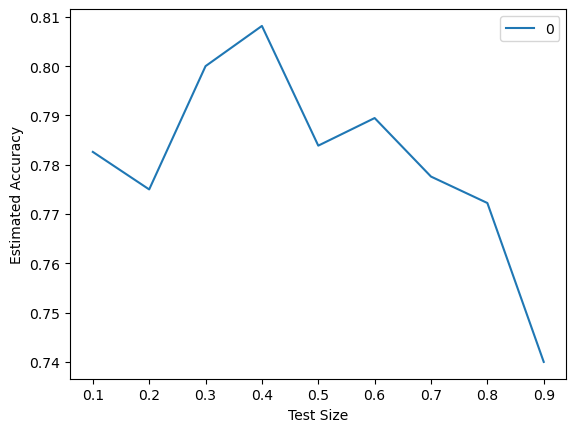

In [107]:
import matplotlib.pyplot as plt

thresholds = []
values = []
for s in range(1, 10):
    cv = ShuffleSplit(n_splits=5, test_size=s/10, random_state=0)
    v = cross_val_score(clf, X, y, cv=cv).mean()
    thresholds.append(s/10)
    values.append(v)

pd.DataFrame(values, index=thresholds).plot()
plt.xlabel('Test Size')
plt.ylabel('Estimated Accuracy')
plt.show()

Note:
- The larger the test size, the smaller the train size
- In general, the accuracy drops when smaller train size
- Around 0.4 we get the highest estimation. It is usual to take 70% of data to Train, and 30% to test

Stability of results

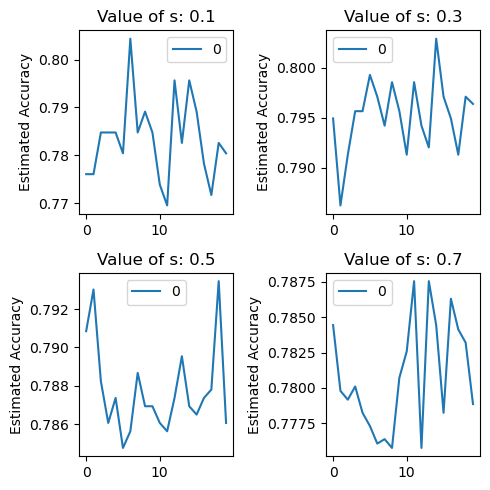

In [144]:
thresholds = [0.1, 0.3, 0.5, 0.7]

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    values = []
    threshold = thresholds[i]
    for _ in range(20):
        cv = ShuffleSplit(n_splits=5, test_size=threshold, random_state=0)
        v = cross_val_score(clf, X, y, cv=cv).mean()
        values.append(v)
    pd.DataFrame(values).plot(ax=ax)
    ax.set_title(f'Value of s: {threshold}')
    ax.set_ylabel('Estimated Accuracy')
    
plt.tight_layout()
plt.show()


### K-fold cross validation

K-fold involves splitting the dataset into K equally sized folds, where K-1 folds are used for training the model, and the remaining fold is used for testing the model. This process is repeated K times, with each fold serving as the test set once.

In [132]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
scores.mean()

0.7798136645962733

### Stratisfied cross validation
It take cares of the class of the objects while performing cross validation

In [146]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10)
scores = cross_val_score(clf, X, y, cv=cv)
print(scores)
scores.mean()

[0.77173913 0.83695652 0.7826087  0.82608696 0.83695652 0.80434783
 0.77173913 0.7826087  0.68131868 0.71428571]


0.7808647873865265

### Leave one out
It performs a n-1 cross validation. It is very time consuming and optimistic

In [147]:
from sklearn.model_selection import LeaveOneOut
cv = LeaveOneOut()
scores = cross_val_score(clf, X, y, cv=cv)
print(scores)
scores.mean()

[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.

0.7908496732026143